In [14]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import xgboost as xgb

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

In [82]:
df = pd.read_csv("./data/current_allday_data.csv.gz")

datecols = ["Datetime", "Date"]
intcols = ["Price", "Sales_Count"]

df[datecols] = df[datecols].apply(pd.to_datetime)
df[intcols] = df[intcols].apply(pd.to_numeric, downcast='integer')

In [83]:
df

,Datetime,Date,tx_id,Price,Buyer,Seller,Player,Team,Position,Season,...,Weight,image,Classification,Total_Circulation,Moment_Description,NFT_ID,Series,Set_Name,NFLALLDAY_ASSETS_URL,Sales_Count
0,2022-05-05 18:49:07,2022-05-05,5d4baa454da25b04d5af5cad22f971ed91ac69ea76f444...,10,0x4c0395008889aa20,0x62754bf5d9f9bdd5,Randall Cunningham,Philadelphia Eagles,QB,1987,...,195.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,9000,Randall Cunningham rolled to his left off of p...,2555093,Historical,Gridiron,https://assets.nflallday.com/editions/gridiron...,1
1,2022-06-15 21:39:01,2022-06-15,6c96ca996a0991d3d3d867c56ef80e53491d1ee7f11fed...,4,0x1762f9a119427234,0x66443cafc920078c,A'Shawn Robinson,Los Angeles Rams,DL,2021,...,330.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,A'Shawn Robinson pushed his way through the li...,1498641,Series 1,Base,https://assets.nflallday.com/editions/base/4b0...,1
2,2022-06-15 19:34:54,2022-06-15,9b40c0168a145f926bea136dbbdaea18911a8715829e75...,220,0xb8eab8b330b6d8f3,0x4d2728f9b1f48c48,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,899,Knowing he had a free play after San Francisco...,1311057,Series 1,Launch Codes,https://assets.nflallday.com/editions/launch_c...,1
3,2022-06-15 19:14:24,2022-06-15,44ed87333faebe4d1c3f038f855c7ed8fafaa8d03b1702...,32,0x3a8896d9962c3edf,0x7dece7a1d46ee9c5,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8500,Blanketed by two defenders near the pylon alon...,2233227,Series 1,Divisional Round,https://assets.nflallday.com/editions/division...,1
4,2022-06-15 20:27:38,2022-06-15,75fe78789e82547c329cb9f7c1ccfcea8495e72b08d3dd...,6,0x2bbe4f847f5d1758,0x4d2728f9b1f48c48,A.J. Green,Arizona Cardinals,WR,2021,...,210.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8000,A.J. Green posted up in the middle of the Seat...,1951312,Series 1,Move the Chains,https://assets.nflallday.com/editions/move_the...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,2022-09-21 09:36:07,2022-09-21,9d6ecd925535329504e43f4a0fe4f9fe3d10883faa3dd9...,35,0x5bb7e65418eb1d4c,0x9f969fa0351ca6b0,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,564156,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602771,2022-09-21 11:31:41,2022-09-21,c0a13ddf4774853713bb5974c00e22715db4e67d079204...,33,0x971a99ee34308dff,0x97475da29ad1ab8e,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,561731,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602772,2022-09-21 06:03:46,2022-09-21,72e40116dca4db82a6ec568d239a88905733c3351424cd...,9,0x1f0315e9e83c607d,0xf44c2d2b8f508092,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3
602773,2022-09-21 05:26:57,2022-09-21,f60a36ab97353b9c579419a72b2bfb42db78eda6a5ff13...,8,0xf44c2d2b8f508092,0x542e12f2d29b171e,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3


In [90]:
rarity_dict = {
    "COMMON": 0,
    "RARE": 1,
    "LEGENDARY": 2,
    "ULTIMATE": 3
}
df["Player"] = df["Player"].astype('category')
df["Play_Type"] = df["Play_Type"].astype('category')
df["Position"] = df["Position"].astype('category')
df["Team"] = df["Team"].astype('category')
df["NFT_ID"] = df["NFT_ID"].astype('category')
df["Rarity"] = df.apply(lambda x: rarity_dict[x.Moment_Tier], axis=1)


In [100]:
features = [
    "Player",
    "Play_Type",
    "Position",
    "Team",
    "Sales_Count",
    "Rarity",
    "NFT_ID",
]
X, y = df[features], df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


In [101]:
X_train.dtypes

Player         category
Play_Type      category
Position       category
Team           category
Sales_Count        int8
Rarity            int64
NFT_ID         category
dtype: object

In [102]:
dtrain=xgb.DMatrix(X_train, y_train, 
                   enable_categorical=True
                  )

In [103]:
dtest=xgb.DMatrix(X_test, y_test, 
                  enable_categorical=True
                 )

In [120]:
param = {
    'max_depth': 7,
    'eta': 0.5,
    'gamma': 1,
    'subsample': 0.9
}


evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(
    param, 
    dtrain, 
    num_round,
    evals=evallist,
    early_stopping_rounds=10
)

[0]	eval-rmse:153.10363	train-rmse:114.46805
[1]	eval-rmse:133.60667	train-rmse:87.47989
[2]	eval-rmse:127.92180	train-rmse:72.01524
[3]	eval-rmse:122.13617	train-rmse:64.66405
[4]	eval-rmse:118.07826	train-rmse:61.55982
[5]	eval-rmse:115.64249	train-rmse:56.92788
[6]	eval-rmse:114.60094	train-rmse:53.75053
[7]	eval-rmse:115.70040	train-rmse:49.08470
[8]	eval-rmse:114.91041	train-rmse:47.65208
[9]	eval-rmse:114.83005	train-rmse:44.74390
[10]	eval-rmse:115.35263	train-rmse:42.97691
[11]	eval-rmse:115.31132	train-rmse:42.69851
[12]	eval-rmse:115.24090	train-rmse:42.43322
[13]	eval-rmse:113.10969	train-rmse:41.90827
[14]	eval-rmse:114.87401	train-rmse:39.98066
[15]	eval-rmse:114.72254	train-rmse:39.66842
[16]	eval-rmse:113.49689	train-rmse:39.31049
[17]	eval-rmse:113.51215	train-rmse:39.21611
[18]	eval-rmse:113.44371	train-rmse:38.72573
[19]	eval-rmse:113.50721	train-rmse:37.48021
[20]	eval-rmse:113.45153	train-rmse:37.05329
[21]	eval-rmse:113.45096	train-rmse:36.56583
[22]	eval-rmse:113.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

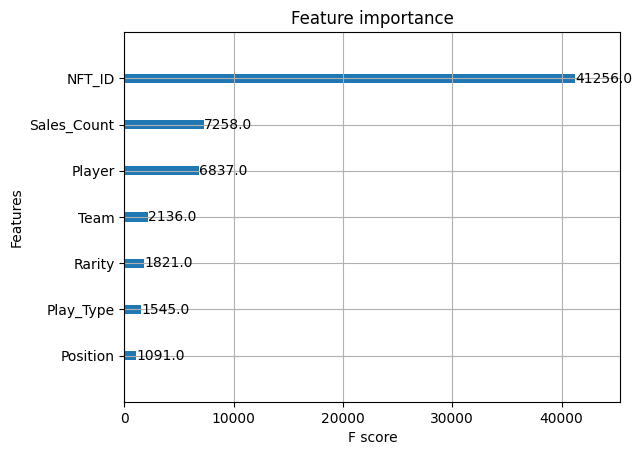

In [121]:
xgb.plot_importance(bst)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

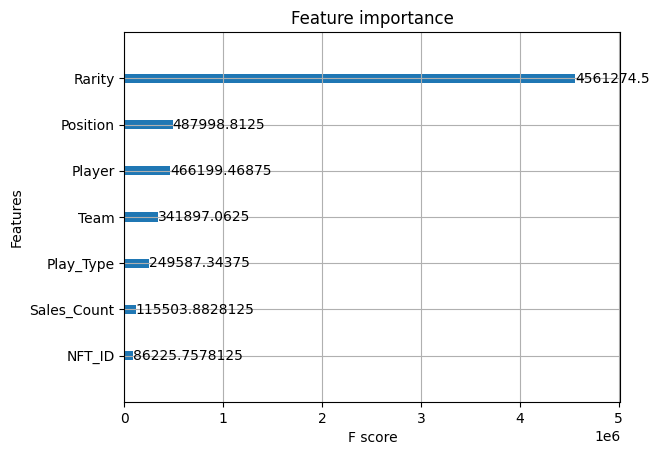

In [122]:
xgb.plot_importance(bst, importance_type='gain')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

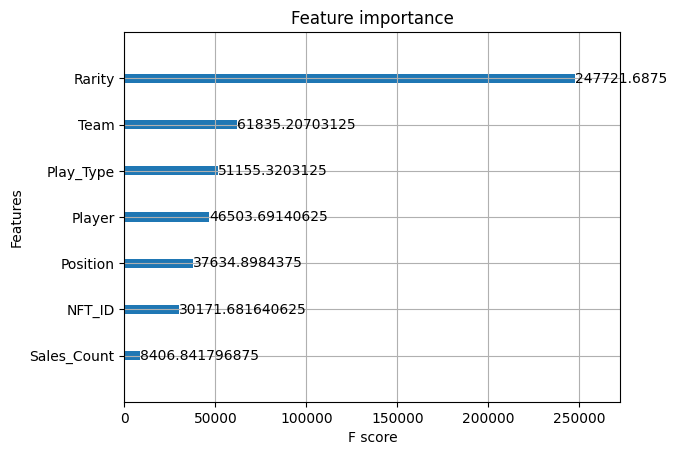

In [123]:
xgb.plot_importance(bst, importance_type='cover')

In [115]:
bst.attributes()

{'best_iteration': '999',
 'best_ntree_limit': '1000',
 'best_score': '16.4455845010143'}

In [116]:
bst.get_fscore()

{'Player': 2305.0,
 'Play_Type': 475.0,
 'Position': 255.0,
 'Team': 635.0,
 'Sales_Count': 3694.0,
 'Rarity': 873.0,
 'NFT_ID': 28782.0}

<AxesSubplot: >

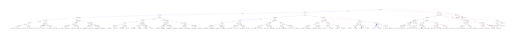

In [70]:
xgb.plot_tree(bst, num_trees=2)

In [65]:
y_test

356804    55
166947     8
285550     8
525303     7
453999    68
          ..
88757      8
364673    12
443606    75
556982    54
57052     31
Name: Price, Length: 120555, dtype: int32

In [32]:
class TypeSelector(BaseEstimator, TransformerMixin):
    '''
    Returns a dataframe while keeping only the columns of the specified dtype
    '''
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
# Class to convert a categorical column into numeric values
class StringIndexer(BaseEstimator, TransformerMixin):
    '''
    Returns a dataframe with the categorical column values replaced with the codes
    Replaces missing value code -1 with a positive integer which is required by OneHotEncoder
    '''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))
    

pipeline = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ]))  # categoricals close
    ])),  # features close
    ("clf", xgb.XGBRegressor(objective="reg:linear", booster="gbtree", nthread=16))
])  # pipeline close

In [33]:
# 'clf__learning_rate': np.arange(0.05, 1.0, 0.05),
# 'clf__n_estimators': np.arange(50, 200, 50)
param_grid = {
    'clf__max_depth': np.arange(3, 10, 1)
}

randomized_mse = RandomizedSearchCV(param_distributions=param_grid, estimator=pipeline, n_iter=2, scoring="neg_mean_squared_error", verbose=1, cv=3)

# Fit the estimator
randomized_mse.fit(X_train, y_train)
print(randomized_mse.best_score_)
print(randomized_mse.best_estimator_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[00:39:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:43] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:39:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
-10595.836358748296
Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=1,
                   

In [35]:
randomized_mse.classes_

AttributeError: 'XGBRegressor' object has no attribute 'classes_'

In [28]:
x_ = pipeline.fit_transform(X_train, y_train)

In [30]:
pd.DataFrame(x_)


KeyboardInterrupt



In [57]:
stats_df_sub = stats_df[
    (stats_df.Play_Type != "Pressure")
    # & (stats_df.Play_Type != "Block")
    & (stats_df.Rarity < 4)
]

In [58]:
stats_df_sub

,Price,Player,Play_Type,Position,Team,Moment_Tier,Sales_Count,NFT_ID,Rarity
0,10,Randall Cunningham,Pass,QB,Philadelphia Eagles,COMMON,1,2555093,1
1,4,A'Shawn Robinson,Sack,DL,Los Angeles Rams,COMMON,1,1498641,1
2,220,A.J. Brown,Reception,WR,Tennessee Titans,RARE,1,1311057,2
3,32,A.J. Brown,Reception,WR,Tennessee Titans,COMMON,1,2233227,1
4,6,A.J. Green,Reception,WR,Arizona Cardinals,COMMON,2,1951312,1
...,...,...,...,...,...,...,...,...,...
602770,35,Zach Wilson,Rush,QB,New York Jets,COMMON,1,564156,1
602771,33,Zach Wilson,Rush,QB,New York Jets,COMMON,1,561731,1
602772,9,Zay Jones,Reception,WR,Las Vegas Raiders,COMMON,3,1472935,1
602773,8,Zay Jones,Reception,WR,Las Vegas Raiders,COMMON,3,1472935,1


In [59]:
md_full = smf.mixedlm(
    "Price ~ Play_Type + Position + Rarity",
    stats_df_sub,
    groups=stats_df_sub["NFT_ID"],
)

In [60]:
mdf_full = md.fit()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


KeyboardInterrupt: 

In [36]:
md = smf.mixedlm(
    "Price ~ Play_Type + Position + Rarity",
    stats_df_sub,
    groups=stats_df_sub["NFT_ID"],
)

In [37]:
mdf = md.fit()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [39]:
s2 = mdf.summary()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [40]:
print(s2)

                                                     Mixed Linear Model Regression Results
Model:                                           MixedLM                              Dependent Variable:                              Price    
No. Observations:                                260406                               Method:                                          REML     
No. Groups:                                      208558                               Scale:                                           4986.3149
Min. group size:                                 1                                    Log-Likelihood:                                  inf      
Max. group size:                                 7                                    Converged:                                       Yes      
Mean group size:                                 1.2                                                                                            
---------------------------------------

In [ ]:
mdf.summary()

In [30]:
s = mdf.summary()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [31]:
print(s)

                                                         Mixed Linear Model Regression Results
Model:                                            MixedLM                                Dependent Variable:                                Price      
No. Observations:                                 260658                                 Method:                                            REML       
No. Groups:                                       208800                                 Scale:                                             273123.5534
Min. group size:                                  1                                      Log-Likelihood:                                    inf        
Max. group size:                                  7                                      Converged:                                         Yes        
Mean group size:                                  1.2                                                                                            

In [52]:
s.extra_txt

[]

In [32]:
mdf2 = md.fit(
    method=["lbfgs"]
     # method=["bfgs"]
)

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


LinAlgError: Singular matrix

In [ ]:
s2 = mdf2.summary()

In [33]:
len(md.group_labels)

208800

In [ ]:

# Ideal
md = smf.mixedlm(
    "Price ~ Player * Play_Type  + Position + Team + Rarity + Sales_Count",
    df,
    groups=df["NFT_ID"],
)

In [19]:
md = smf.mixedlm(
    "Price ~ Player + Play_Type + Moment_Tier ",
    df,
    groups=df["NFT_ID"],
)